 Data Overview
Shape: (145, 16)

Columns:
 ['Unnamed: 0', 'Id', 'Student_Age', 'Sex', 'High_School_Type', 'Scholarship', 'Additional_Work', 'Sports_activity', 'Transportation', 'Weekly_Study_Hours', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work', 'Grade']

Data Types:
 Unnamed: 0             int64
Id                     int64
Student_Age            int64
Sex                   object
High_School_Type      object
Scholarship           object
Additional_Work       object
Sports_activity       object
Transportation        object
Weekly_Study_Hours     int64
Attendance            object
Reading               object
Notes                 object
Listening_in_Class    object
Project_work          object
Grade                 object
dtype: object

Missing Values:
 Unnamed: 0            0
Id                    0
Student_Age           0
Sex                   0
High_School_Type      0
Scholarship           1
Additional_Work       0
Sports_activity       0
Transportation    

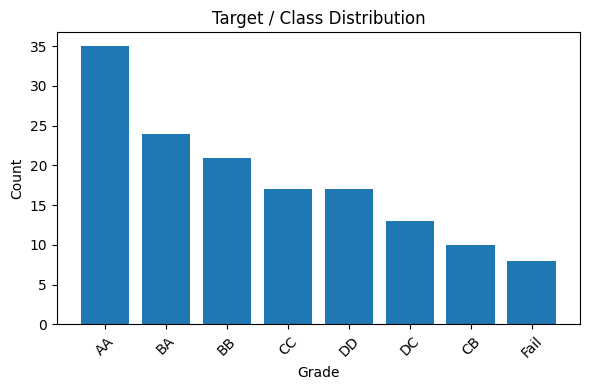

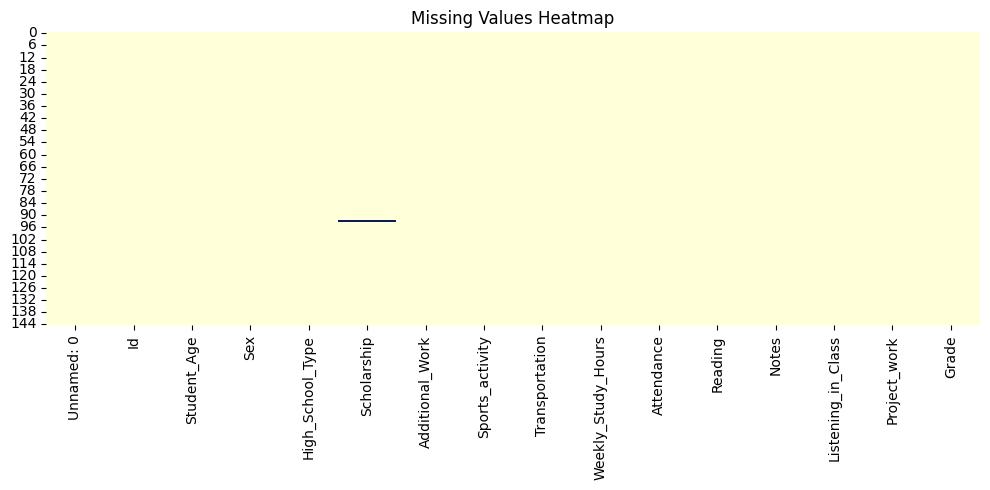

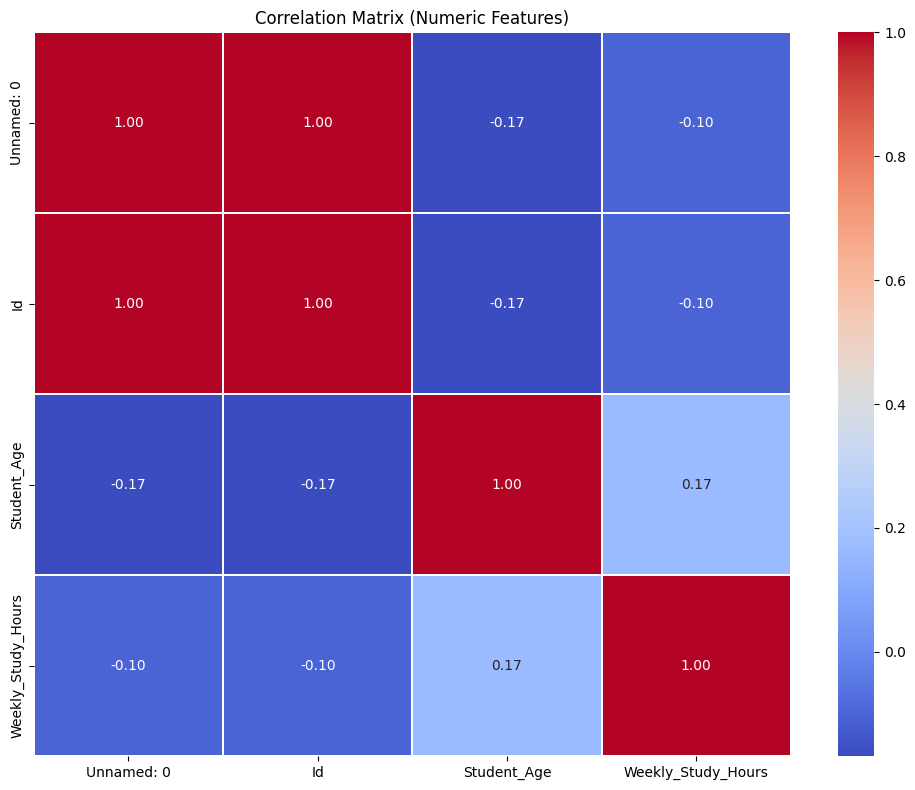

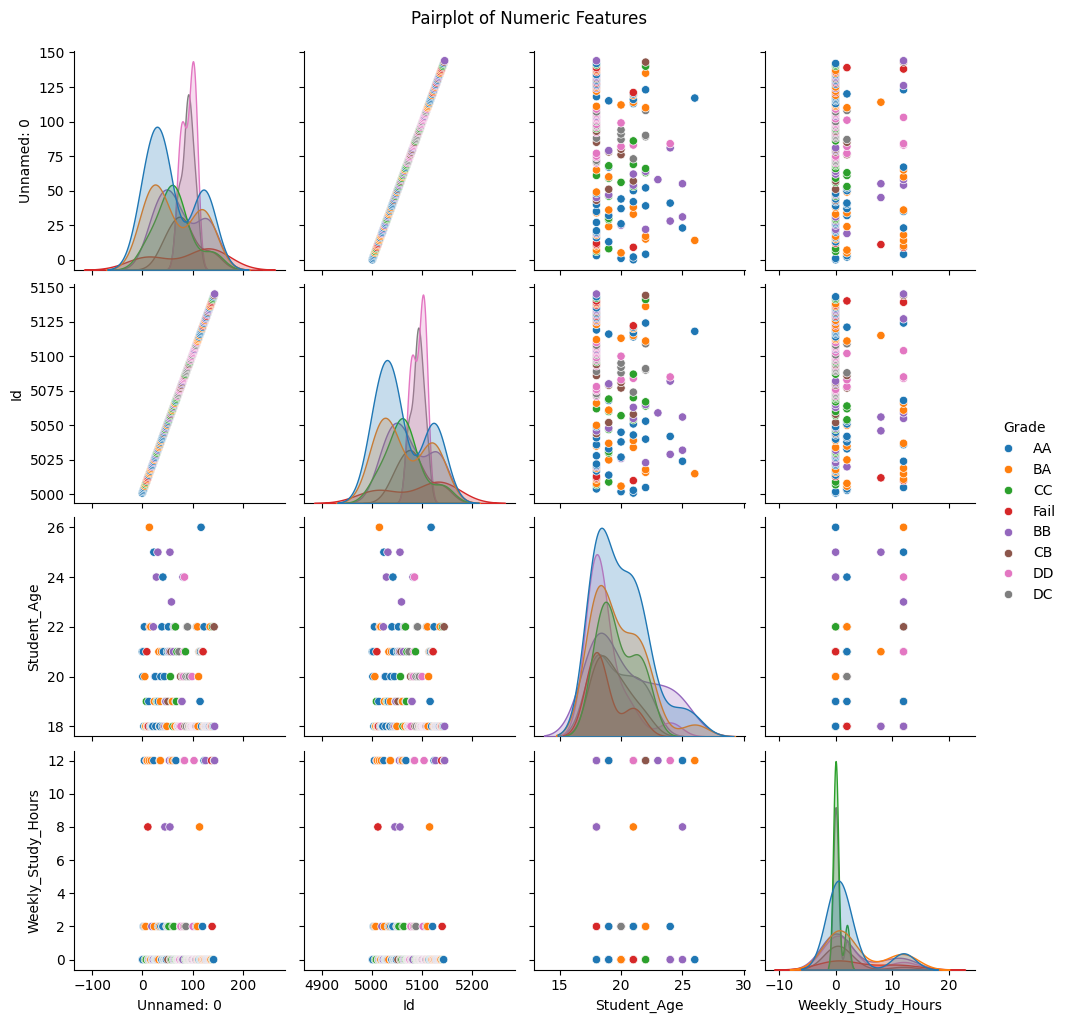

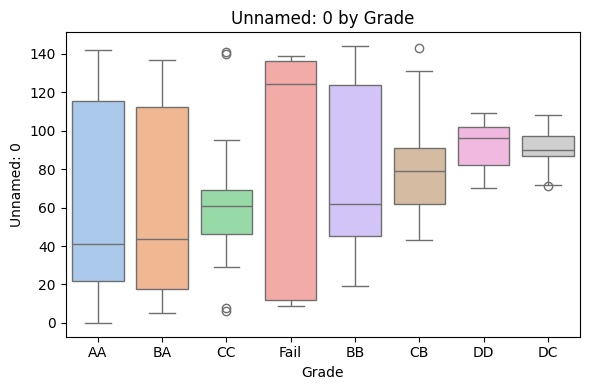

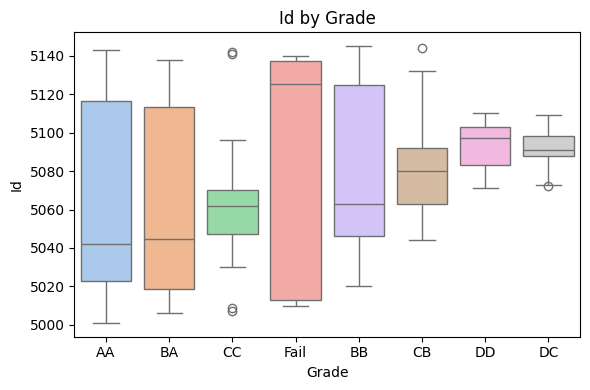

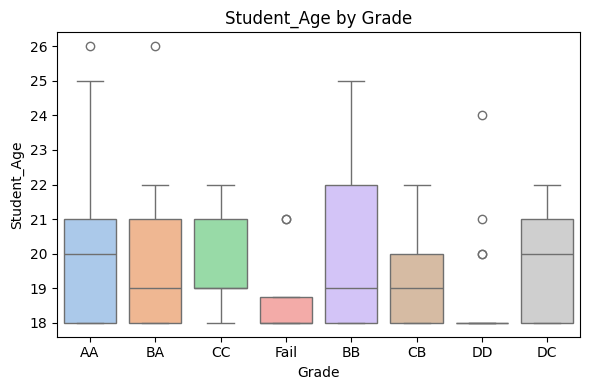

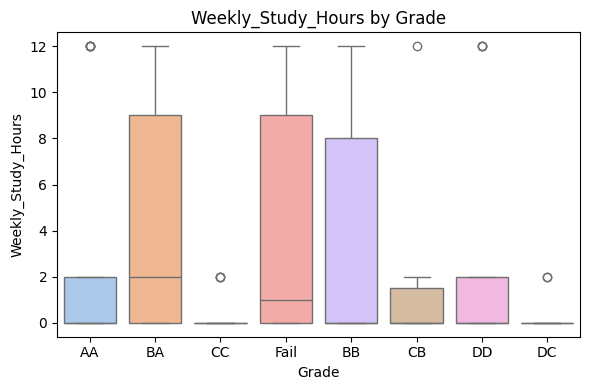

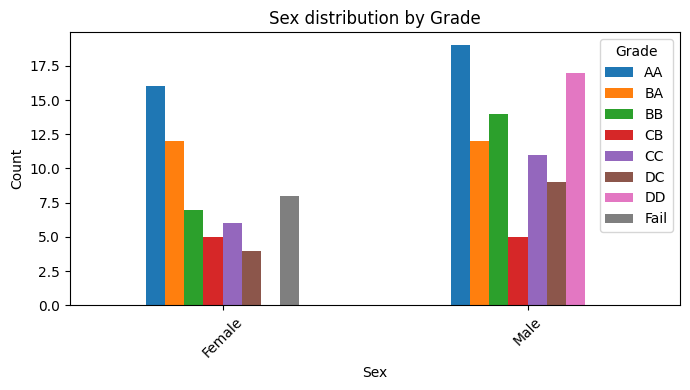

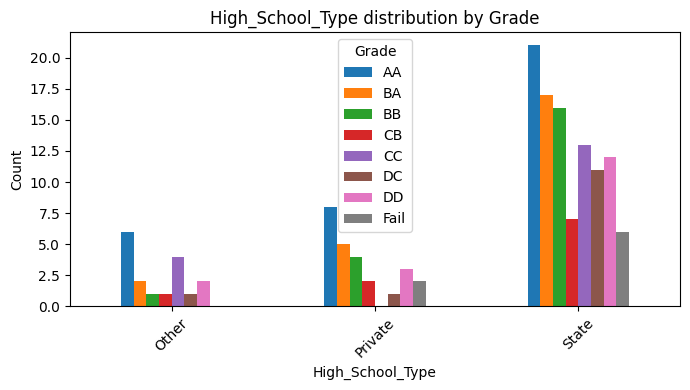

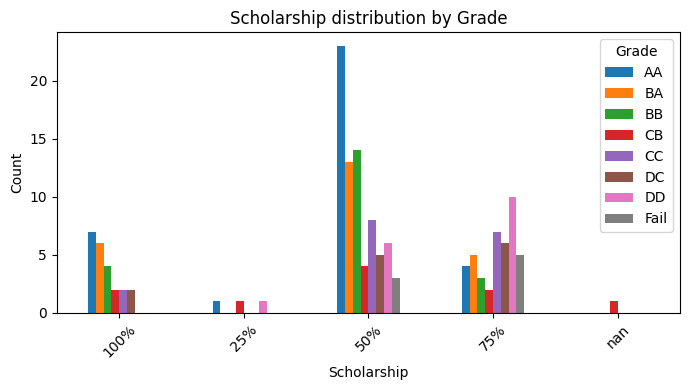

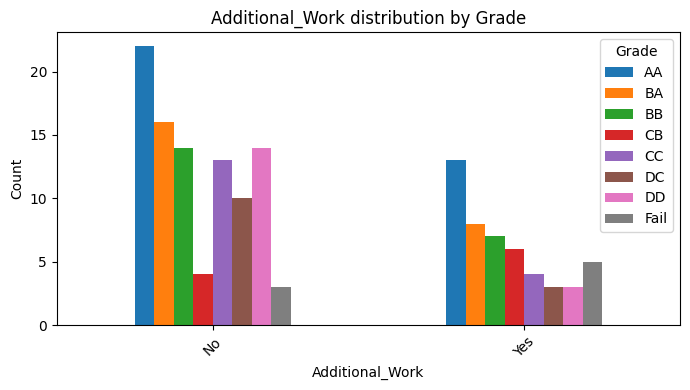

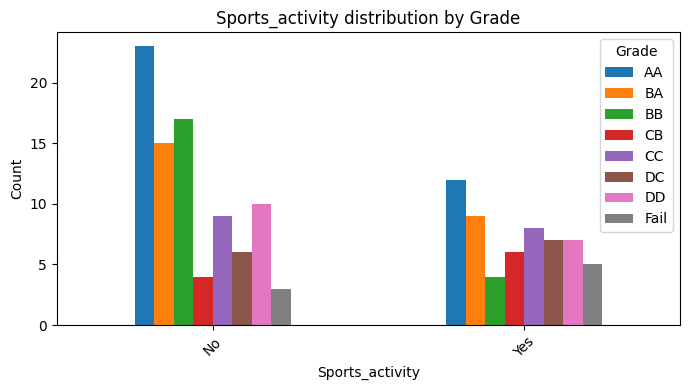

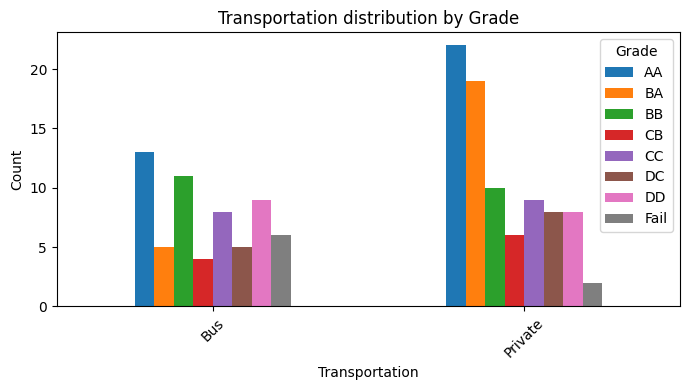

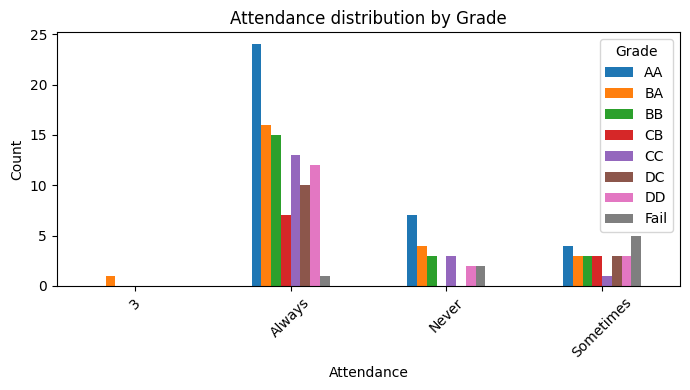

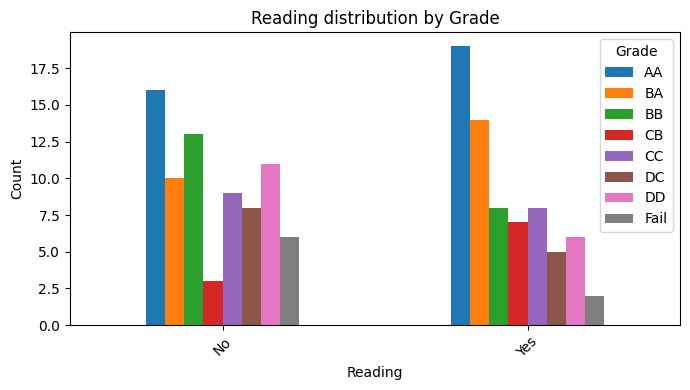

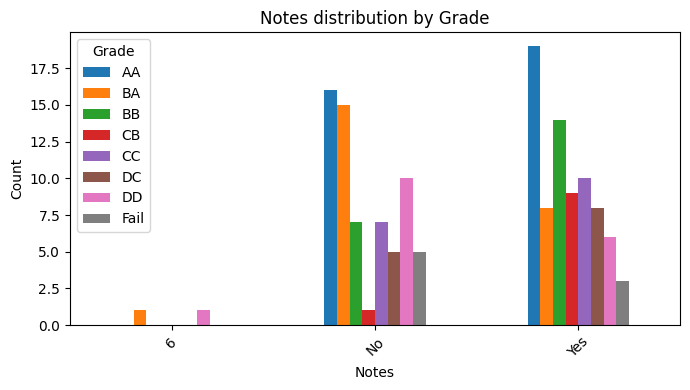

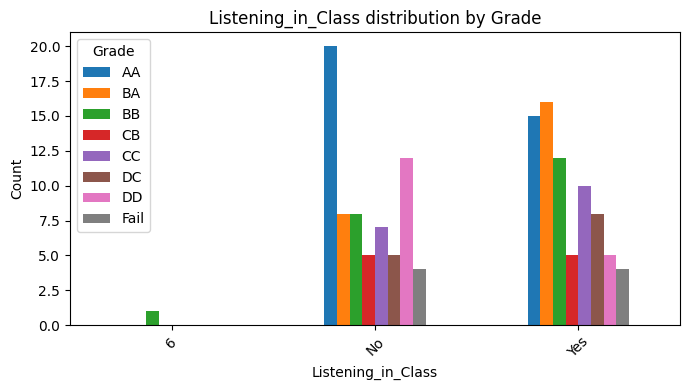

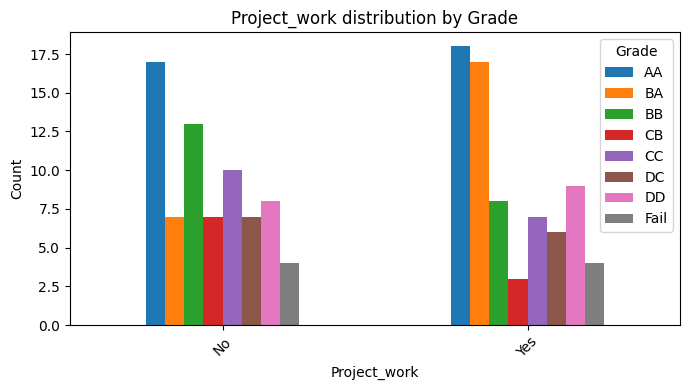

In [3]:
# Exploratory Data Analysis (EDA)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
FILE = r"C:\Data\student_classification_dataset.csv"  # adjust if needed
df = pd.read_csv(FILE)
df = df.reset_index(drop=True)  # avoid index-related seaborn/pandas quirks

# 2. Basic overview
print(" Data Overview" )
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nFirst 5 Rows:")
print(df.head())


# 2.1 Duplicate check  
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

if duplicates > 0:
    print("\nExample duplicate rows:")
    print(df[df.duplicated()].head())
    
# Optionally remove duplicates 
df = df.drop_duplicates().reset_index(drop=True)
print(f"\nDuplicates removed. New shape: {df.shape}")


# 3. Identify target column (class label)
possible_targets = ["performance_category", "class", "target", "label", "grade_category", "performance"]
target = None
for c in possible_targets:
    if c in df.columns:
        target = c
        break
if target is None:
    # fallback: last non-numeric column, else last column
    nonnum = [c for c in df.columns if df[c].dtype == "object"]
    target = nonnum[-1] if nonnum else df.columns[-1]
print(f"\nTarget column: {target}")

# 4. Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target]]

print("\nNumeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

# 5. Descriptive statistics
if numeric_cols:
    print("\n NUMERIC SUMMARY ")
    print(df[numeric_cols].describe().T)

print("\n CATEGORICAL SUMMARY ")
for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].astype(str).value_counts(dropna=False))

# 6. Target distribution (robust: matplotlib)
vc = df[target].astype(str).value_counts(dropna=False)
plt.figure(figsize=(6,4))
plt.bar(vc.index, vc.values)
plt.title("Target / Class Distribution")
plt.xlabel(target)
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Missing values heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

# 8. Numeric correlation heatmap
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    corr = df[numeric_cols].corr(numeric_only=True)
    sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.3)
    plt.title("Correlation Matrix (Numeric Features)")
    plt.tight_layout()
    plt.show()

# 9. Pairplot (optional for small datasets) - guarded
try:
    if 2 <= len(numeric_cols) <= 6 and df.shape[0] <= 1000:
        sns.pairplot(df[numeric_cols + [target]].dropna(), hue=target, diag_kind="kde")
        plt.suptitle("Pairplot of Numeric Features", y=1.02)
        plt.show()
except Exception as e:
    print("Pairplot skipped:", e)

# 10. Boxplots: Feature vs Target 
for col in numeric_cols:
    try:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[target].astype(str), y=df[col], palette="pastel")
        plt.title(f"{col} by {target}")
        plt.xlabel(target)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Boxplot for {col} skipped:", e)

# 11. Categorical feature distributions by Target 
for col in categorical_cols:
    try:
        ct = pd.crosstab(df[col].astype(str), df[target].astype(str))
        ax = ct.plot(kind="bar", figsize=(7,4))
        ax.set_title(f"{col} distribution by {target}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"{col} distribution plot skipped:", e)


Target column detected: Grade
Decision Tree trained. Classes: ['AA', 'BA', 'BB', 'CB', 'CC', 'DC', 'DD', 'Fail']


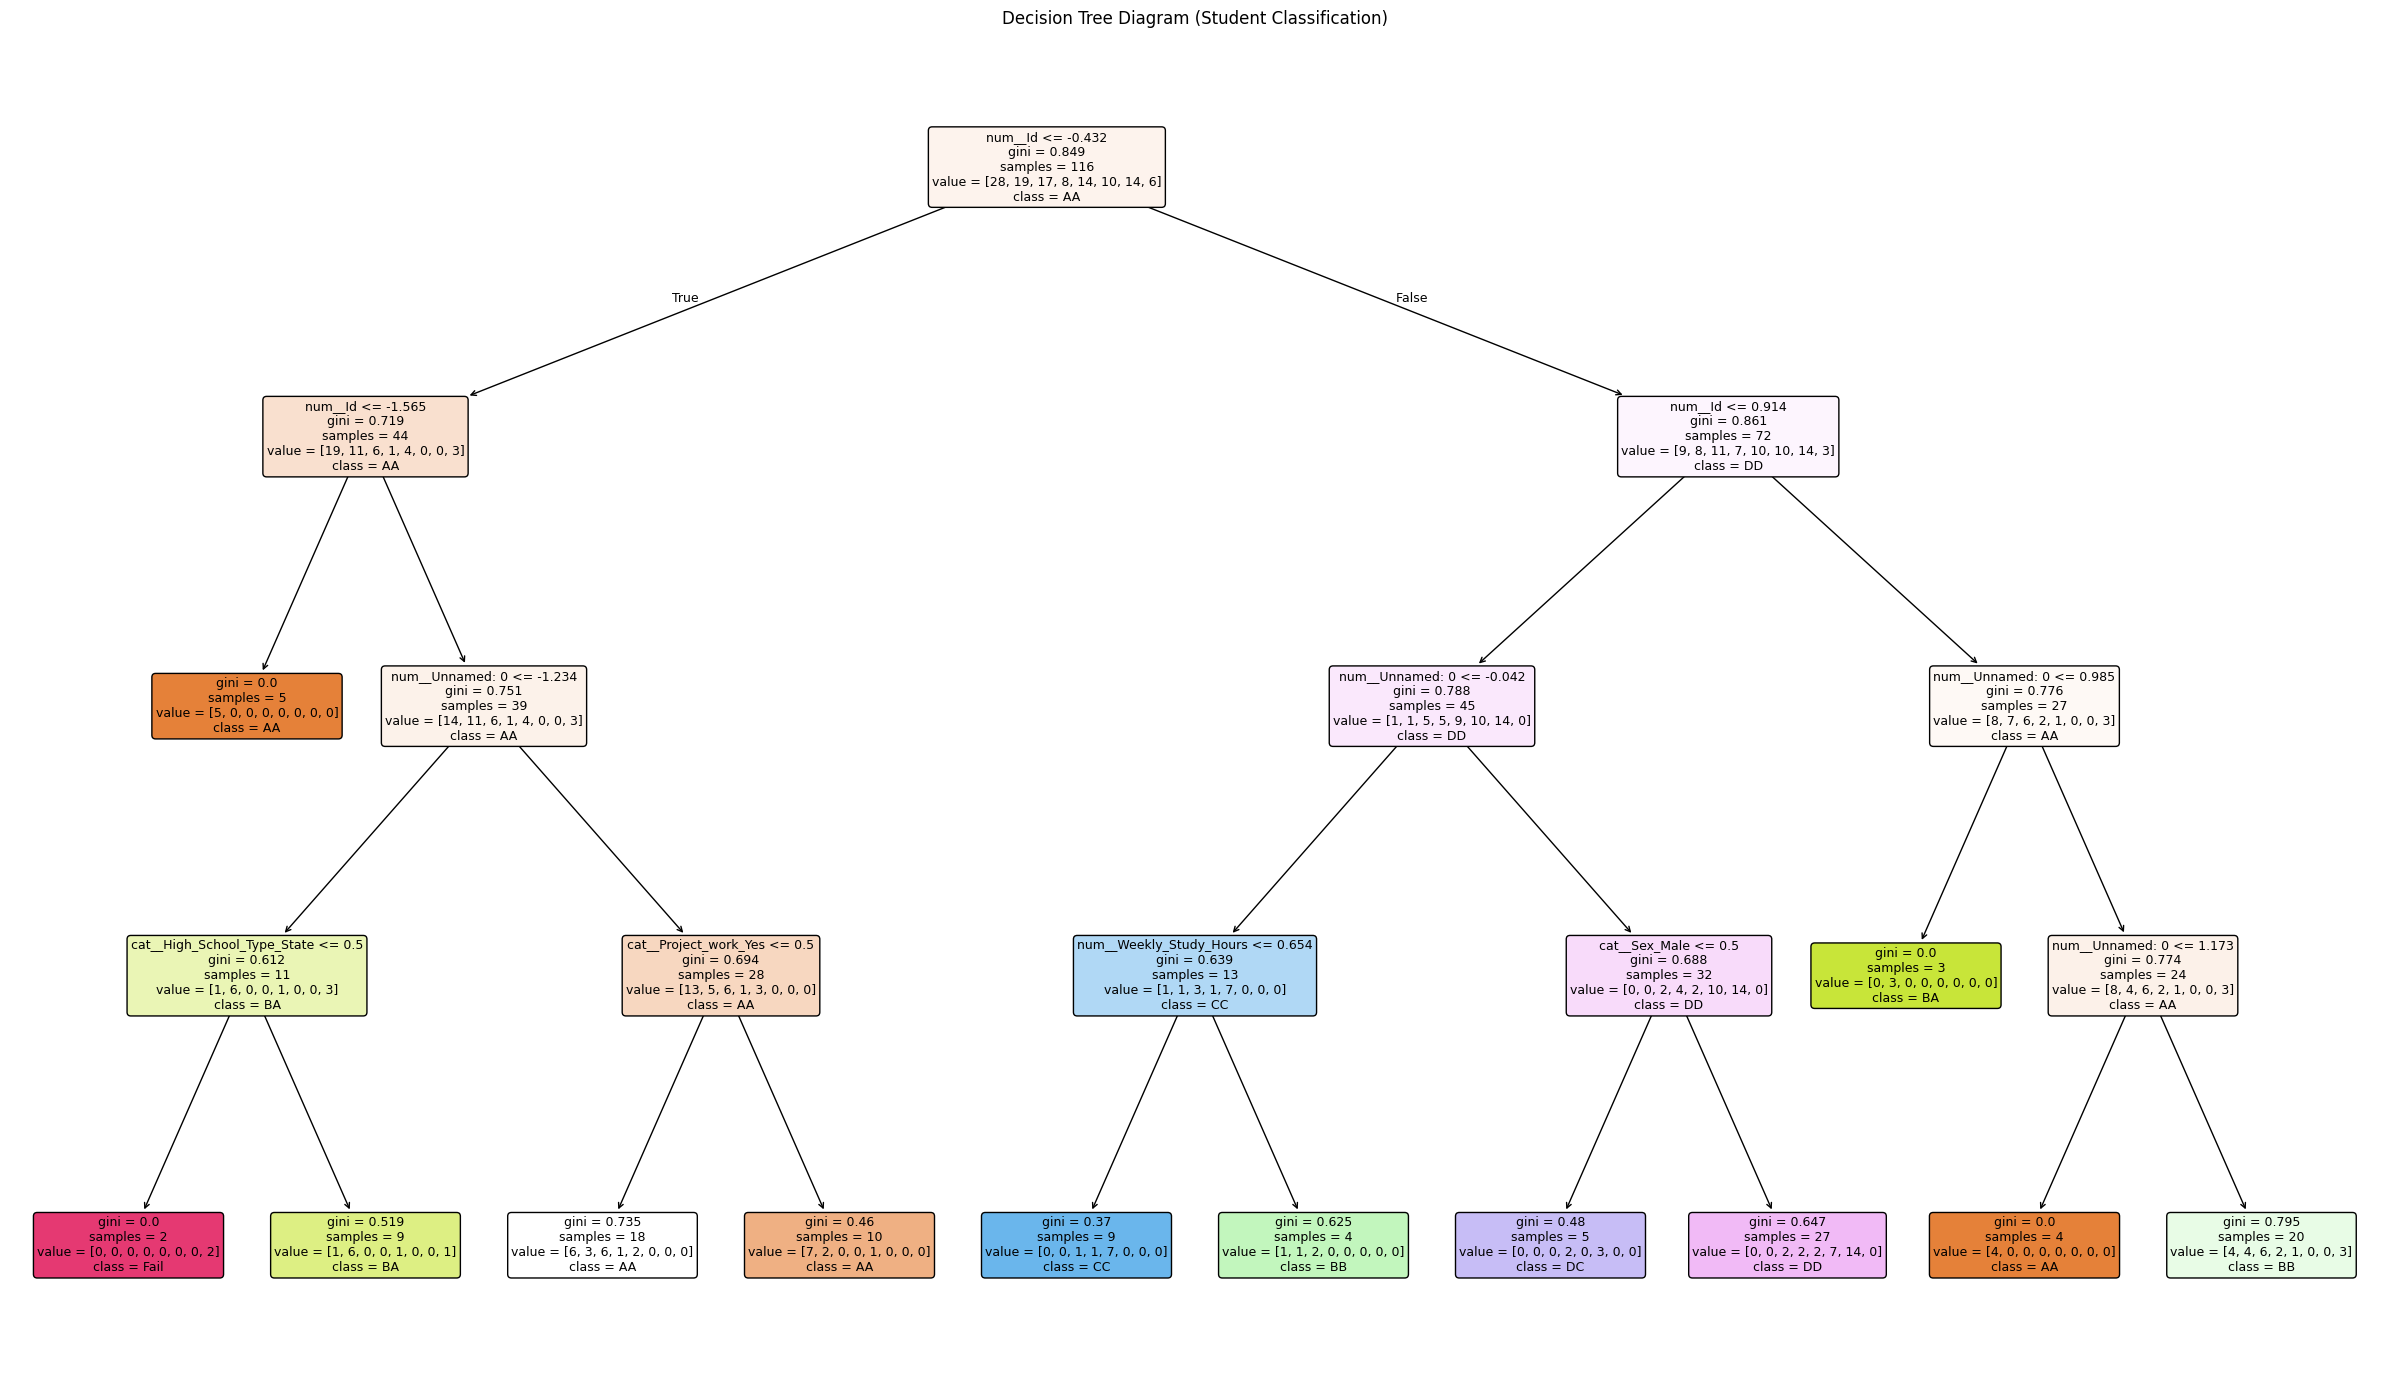

 Diagram saved as 'decision_tree_diagram.png' in the current directory.


In [3]:
# Decision Tree Training + Diagram 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1) Load dataset

CSV_PATH = r"C:\Data\student_classification_dataset.csv"  # change if needed
df = pd.read_csv(CSV_PATH).reset_index(drop=True)

# Drop ID-like columns if present
for col in ["id", "student_id", "index"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# 2) Identify target column
candidates = ["performance_category", "class", "target", "label", "grade_category", "performance"]
target = next((c for c in candidates if c in df.columns), None)
if target is None:
    nonnum = [c for c in df.columns if df[c].dtype == "object"]
    target = nonnum[-1] if nonnum else df.columns[-1]
print(f"Target column detected: {target}")

# 3) Split features and labels

X = df.drop(columns=[target])
y_raw = df[target]

# Encode labels (e.g., "Excellent" -> 2, "Average" -> 1, "Poor" -> 0)
lbl = LabelEncoder()
y = lbl.fit_transform(y_raw)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5) Preprocessing
#    (NOTE: use sparse_output=False for sklearn >= 1.4)-
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])

# Fit-transform for visualization
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Feature names for plotting
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = np.array([f"f_{i}" for i in range(X_train_enc.shape[1])])

# 6) Train a compact Decision Tree (for clear diagram)

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,        # increase if you want more detail
    min_samples_leaf=2
)
dt.fit(X_train_enc, y_train)
print(f"Decision Tree trained. Classes: {list(lbl.classes_)}")

# 7) Plot & save the tree diagram
plt.figure(figsize=(24, 14))
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=lbl.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=9,
    impurity=True
)
plt.title("Decision Tree Diagram (Student Classification)")
plt.tight_layout()
plt.savefig("decision_tree_diagram.png", dpi=200)
plt.show()

print(" Diagram saved as 'decision_tree_diagram.png' in the current directory.")


In [ ]:
# ===== EDA: student_classification_dataset =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 110

# 1) Load
FILE = r"C:\Data\student_classification_dataset.csv"
df = pd.read_csv(FILE).reset_index(drop=True)

# 2) Overview
print(" Data Overview")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values (count):\n", df.isnull().sum().sort_values(ascending=False))
print("\nFirst 5 Rows:")
print(df.head())

# 2.1) Duplicates
dups = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dups}")
if dups > 0:
    print(df[df.duplicated()].head())
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

# 3) Target detection
possible_targets = ["performance_category", "class", "target", "label", "grade_category", "performance"]
target = next((c for c in possible_targets if c in df.columns), None)
if target is None:
    nonnum = [c for c in df.columns if df[c].dtype == "object"]
    target = nonnum[-1] if nonnum else df.columns[-1]
print("Target column:", target)

# 4) Types (exclude target from numeric)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target]]
print("\nNumeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

# 5) Descriptives
if numeric_cols:
    print("\n NUMERIC SUMMARY ")
    print(df[numeric_cols].describe().T)

print("\n CATEGORICAL SUMMARY (top 10)")
for col in categorical_cols:
    vc = df[col].astype(str).value_counts(dropna=False)
    print(f"\n{col} ({len(vc)} unique):")
    print(vc.head(10))

# 6) Target distribution (count + %)
vc = df[target].astype(str).value_counts(dropna=False)
vp = (vc / vc.sum() * 100).round(2)
print("\nTarget counts:\n", vc)
print("\nTarget percent:\n", vp)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(vc.index, vc.values, color="skyblue")
ax[0].set_title("Target Counts")
ax[0].set_xlabel(target)
ax[0].set_ylabel("Count")
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(vp.index, vp.values, color="lightgreen")
ax[1].set_title("Target Percent")
ax[1].set_xlabel(target)
ax[1].set_ylabel("%")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 7) Missing heatmap + bar
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

miss_counts = df.isnull().sum().sort_values(ascending=False)
if miss_counts.iloc[0] > 0:
    plt.figure(figsize=(10,4))
    miss_counts[miss_counts > 0].plot(kind="bar", color="coral")
    plt.title("Missing Values by Column")
    plt.ylabel("Missing")
    plt.tight_layout()
    plt.show()

# 8) Correlation (numeric)
if len(numeric_cols) > 1:
    try:
        corr = df[numeric_cols].corr(numeric_only=True)
    except TypeError:
        corr = df[numeric_cols].corr()

    plt.figure(figsize=(min(1.2*len(numeric_cols), 12), min(1.0*len(numeric_cols), 10)))
    sns.heatmap(corr, cmap="coolwarm", annot=(len(numeric_cols) <= 10), fmt=".2f", linewidths=0.3)
    plt.title("Correlation Matrix (Numeric)")
    plt.tight_layout()
    plt.show()

# 9) Boxplots: numeric vs target (fixed warning)
for col in numeric_cols:
    try:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x=target, y=col, hue=target, legend=False, palette="pastel")
        plt.title(f"{col} by {target}")
        plt.xlabel(target)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Boxplot for {col} skipped:", e)

# 10) Categorical crosstab vs target
for col in categorical_cols:
    try:
        if df[col].nunique(dropna=False) > 40:
            print(f"{col}: high cardinality, skipping bar crosstab.")
            continue
        ct = pd.crosstab(df[col].astype(str), df[target].astype(str))
        ax = ct.plot(kind="bar", figsize=(7,4), colormap="Paired")
        ax.set_title(f"{col} distribution by {target}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"{col} crosstab skipped:", e)


Target column: Grade
Numeric cols: ['Id', 'Student_Age', 'Weekly_Study_Hours']
Categorical cols: ['Sex', 'High_School_Type', 'Scholarship', 'Additional_Work', 'Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work']


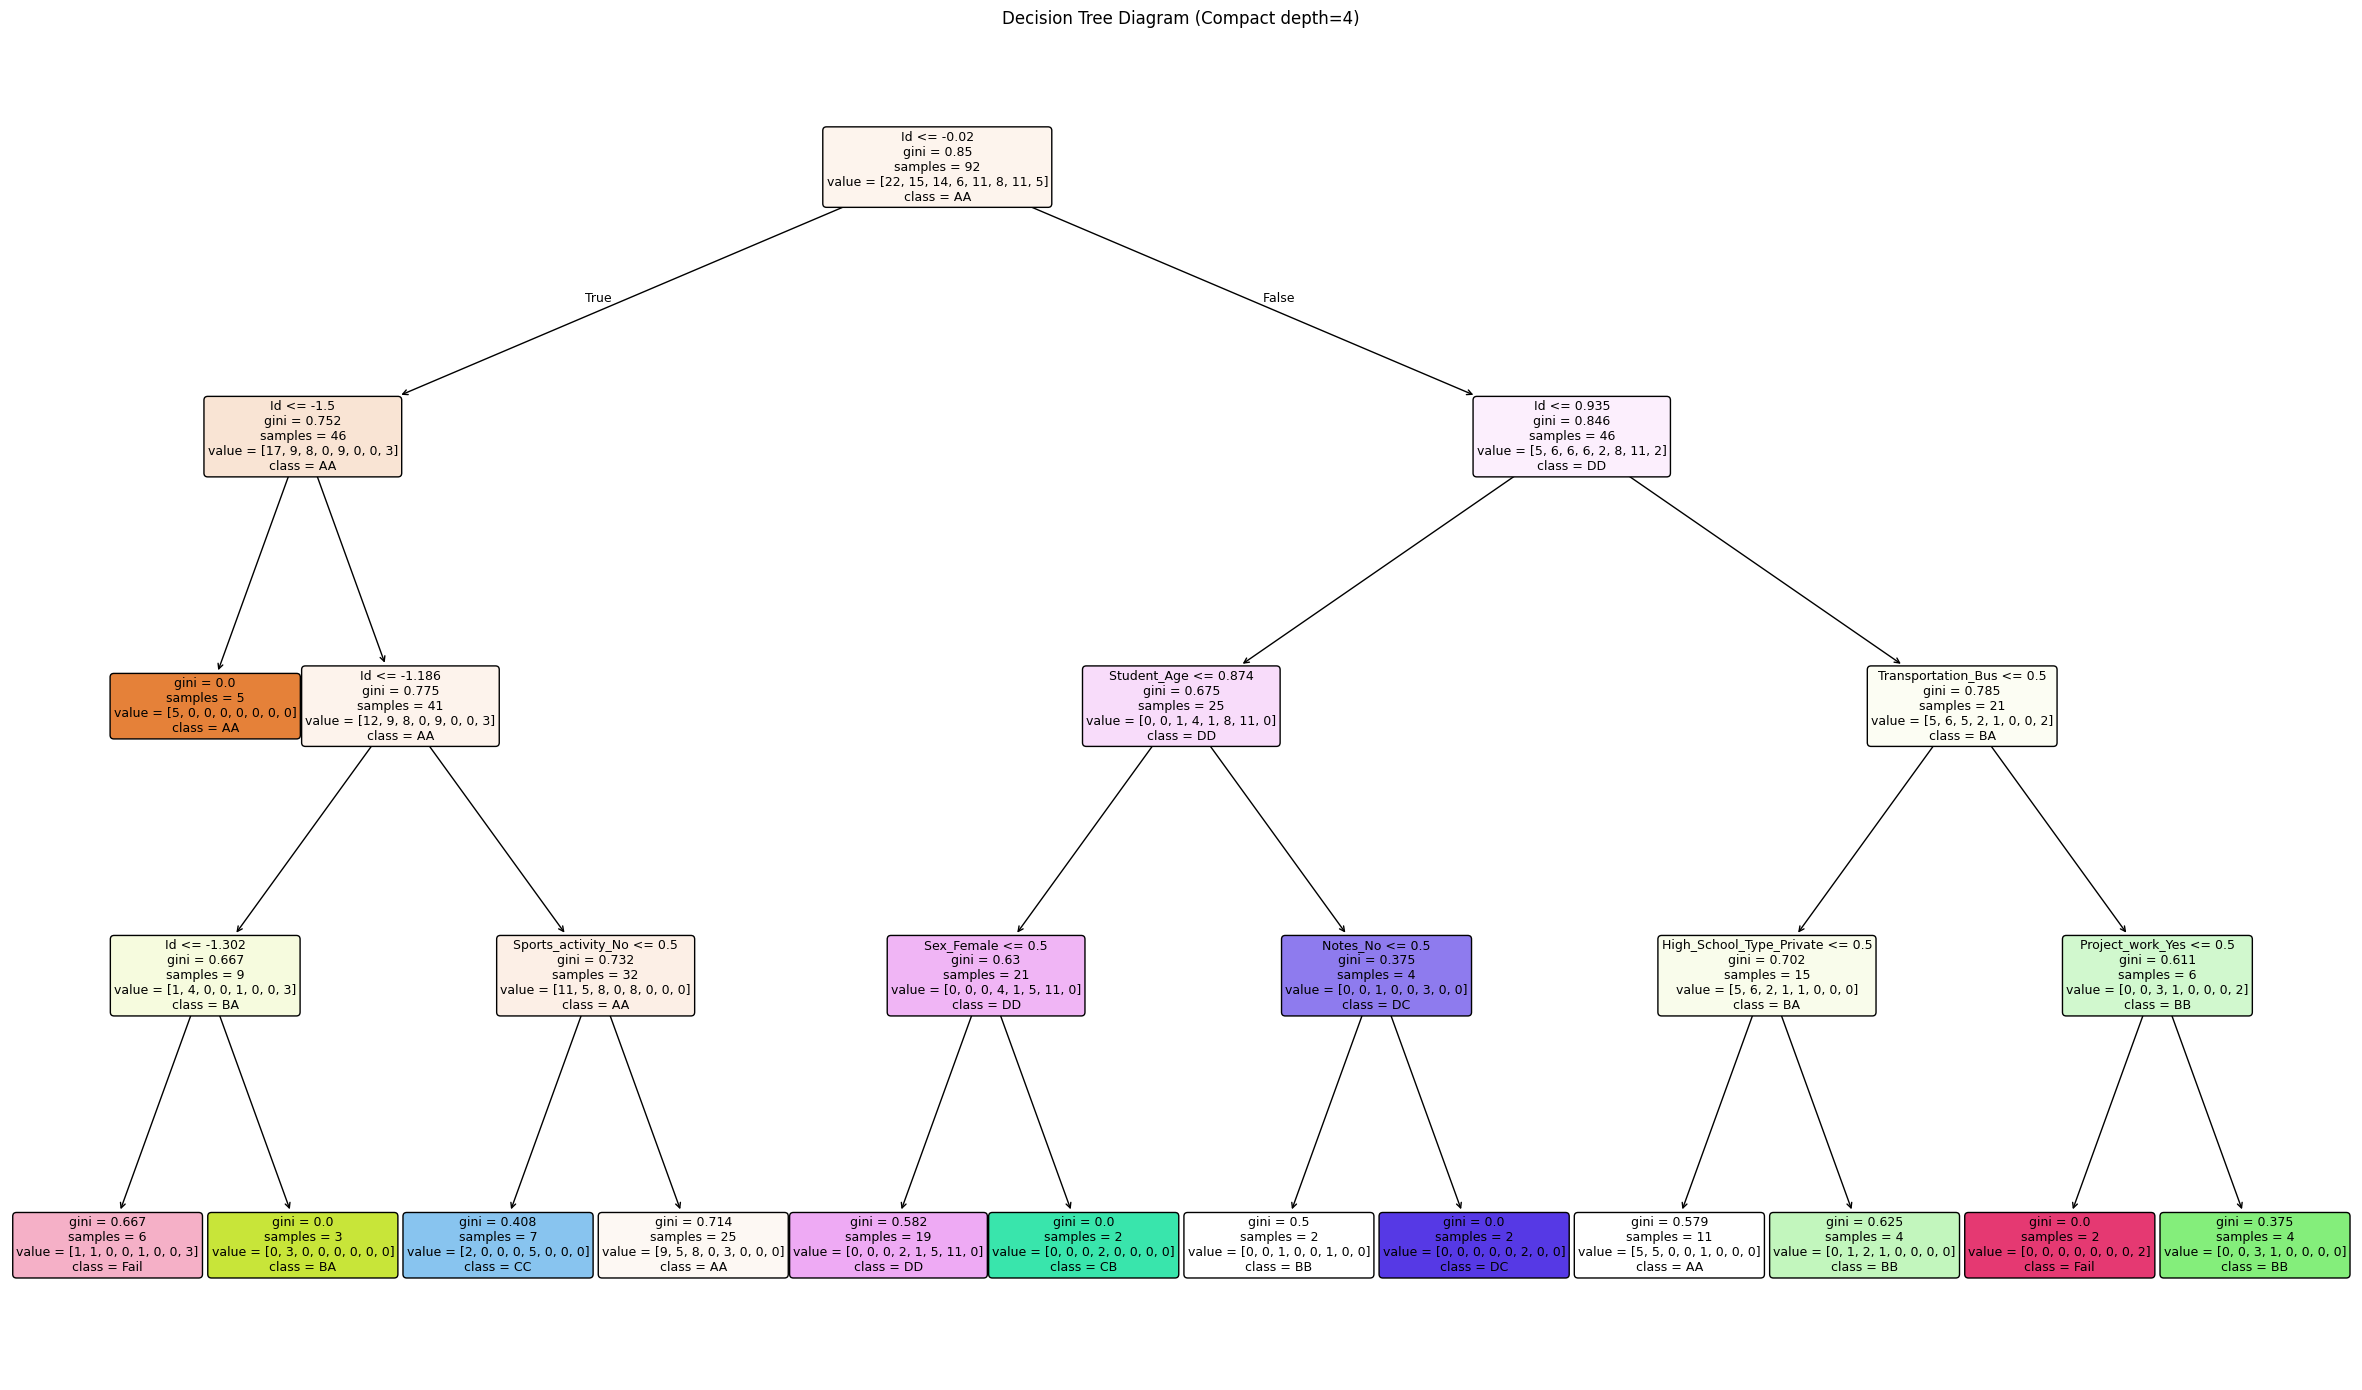

Saved: decision_tree_diagram.png
Best DT params: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2} | CV macro-F1: 0.3227

Decision Tree — Test
Accuracy: 0.2414
              precision    recall  f1-score   support

          AA     0.2500    0.1429    0.1818         7
          BA     0.5000    0.6000    0.5455         5
          BB     0.0000    0.0000    0.0000         4
          CB     0.0000    0.0000    0.0000         2
          CC     0.2500    0.3333    0.2857         3
          DC     0.0000    0.0000    0.0000         3
          DD     0.2857    0.6667    0.4000         3
        Fail     0.0000    0.0000    0.0000         2

    accuracy                         0.2414        29
   macro avg     0.1607    0.2179    0.1766        29
weighted avg     0.2020    0.2414    0.2089        29



<Figure size 640x480 with 0 Axes>

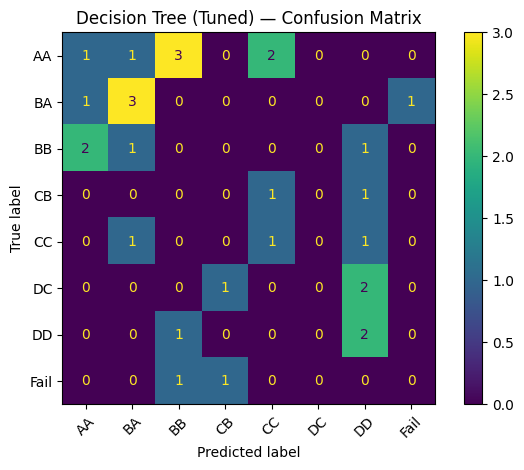

Best FNN config: {'width': 256, 'depth': 2, 'dropout': 0.3, 'lr': 0.0005} | Val macro-F1: 0.2167

FNN — Test
Accuracy: 0.1379
              precision    recall  f1-score   support

          AA     0.1000    0.1429    0.1176         7
          BA     0.0000    0.0000    0.0000         5
          BB     0.1250    0.2500    0.1667         4
          CB     0.0000    0.0000    0.0000         2
          CC     0.0000    0.0000    0.0000         3
          DC     0.0000    0.0000    0.0000         3
          DD     0.3333    0.3333    0.3333         3
        Fail     0.1250    0.5000    0.2000         2

    accuracy                         0.1379        29
   macro avg     0.0854    0.1533    0.1022        29
weighted avg     0.0845    0.1379    0.0997        29



<Figure size 640x480 with 0 Axes>

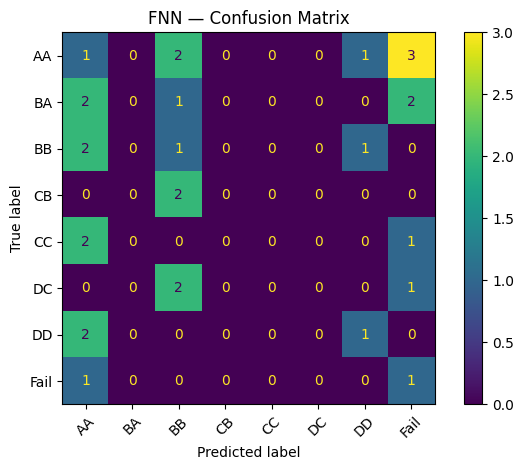

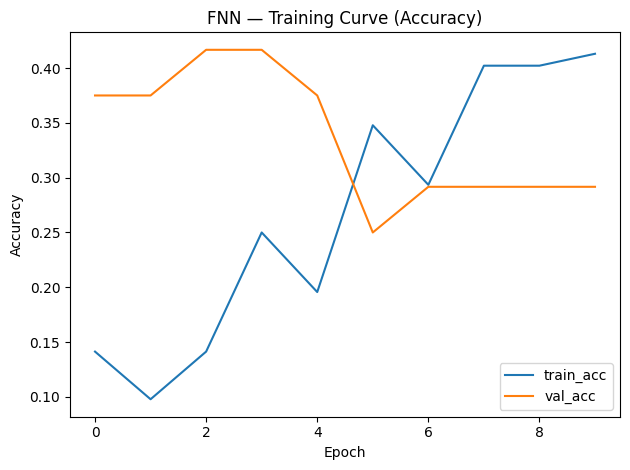

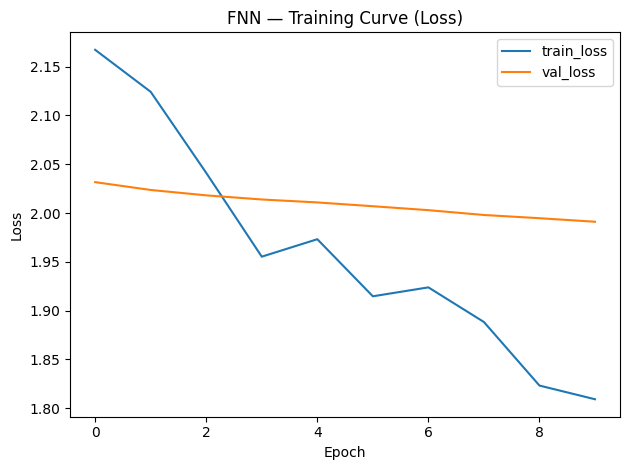


Hybrid — best alpha (val) = 0.93 | Val macro-F1 = 0.3631

Hybrid (Blending) — Test
Accuracy: 0.2069
              precision    recall  f1-score   support

          AA     0.1667    0.1429    0.1538         7
          BA     0.3333    0.2000    0.2500         5
          BB     0.2000    0.2500    0.2222         4
          CB     0.0000    0.0000    0.0000         2
          CC     0.2500    0.3333    0.2857         3
          DC     0.0000    0.0000    0.0000         3
          DD     0.2857    0.6667    0.4000         3
        Fail     0.0000    0.0000    0.0000         2

    accuracy                         0.2069        29
   macro avg     0.1545    0.1991    0.1640        29
weighted avg     0.1807    0.2069    0.1818        29



<Figure size 640x480 with 0 Axes>

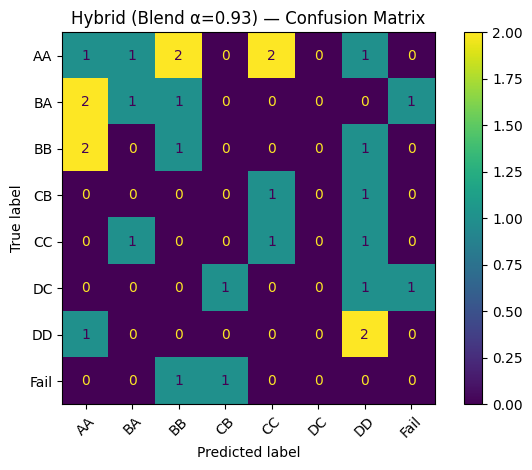


ROC-AUC — DT: 0.6009 | FNN: 0.5310 | Hybrid: 0.6028

Summary (sorted by Macro-F1 then Accuracy)
                Model  Accuracy  Macro-F1
Decision Tree (tuned)  0.241379  0.176623
      Hybrid (α=0.93)  0.206897  0.163973
          FNN (tuned)  0.137931  0.102206


In [3]:
# Modeling: Preprocessing + Decision Tree + FNN + Hybrid (Blending) without feature engineering
# Uses the SAME target detection and column typing as the EDA script.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Silence TF logging + typical retracing spam
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
tf.get_logger().setLevel("ERROR")   # reduce python-level TF warnings

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# 1) Load (same dataset)
CSV_PATH = r"C:\Data\student_classification_dataset.csv"
df = pd.read_csv(CSV_PATH).reset_index(drop=True)

# Optional: drop obvious IDs
for col in ["id", "student_id", "index"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# 2) Target detection (identical to EDA)
possible_targets = ["performance_category", "class", "target", "label", "grade_category", "performance"]
target = next((c for c in possible_targets if c in df.columns), None)
if target is None:
    nonnum = [c for c in df.columns if df[c].dtype == "object"]
    target = nonnum[-1] if nonnum else df.columns[-1]
print("Target column:", target)

# 3) Types (EXACT match with EDA)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target]]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# 4) Split X/y
X = df.drop(columns=[target])
y_raw = df[target]
lbl = LabelEncoder()
y = lbl.fit_transform(y_raw)
class_names = [str(c) for c in lbl.classes_]
n_classes = len(class_names)

# Train/Val/Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# 5) Preprocessing — SAME rules as EDA
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # older sklearn

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preproc = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
], remainder="drop")

# Fit on training; transform sets
X_train_t = preproc.fit_transform(X_train)
X_val_t   = preproc.transform(X_val)
X_test_t  = preproc.transform(X_test)

# Helper: feature names for diagrams/importance
def get_feature_names(ct: ColumnTransformer) -> list:
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            oh = trans.named_steps.get("onehot", None)
            if oh is not None and hasattr(oh, "get_feature_names_out"):
                names.extend(list(oh.get_feature_names_out(cols)))
            else:
                names.extend(list(cols))
        else:
            names.extend(list(cols))
    return names

try:
    feature_names = np.array(get_feature_names(preproc))
except Exception:
    feature_names = np.array([f"f_{i}" for i in range(X_train_t.shape[1])])

# 6) Decision Tree — (A) compact diagram, (B) tuned model
# (A) Compact tree only for a readable diagram
dt_compact = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=2)
dt_compact.fit(X_train_t, y_train)

plt.figure(figsize=(24, 14))
plot_tree(
    dt_compact,
    feature_names=feature_names,
    class_names=class_names,
    filled=True, rounded=True, fontsize=9, impurity=True
)
plt.title("Decision Tree Diagram (Compact depth=4)")
plt.tight_layout()
plt.savefig("decision_tree_diagram.png", dpi=220)
plt.show()
print("Saved: decision_tree_diagram.png")

# (B) Tuned DT for performance
dt_pipe = Pipeline([
    ("pre", preproc),
    ("dt", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "dt__max_depth": [None, 3, 5, 8, 12, 16],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 4, 8],
    "dt__class_weight": [None, "balanced"]
}

counts = np.bincount(y_train)
safe_splits = int(max(2, min(5, counts.min())))  # avoid tiny-class CV errors
cv = StratifiedKFold(n_splits=safe_splits, shuffle=True, random_state=42)

gs_dt = GridSearchCV(dt_pipe, param_grid_dt, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_
print("Best DT params:", gs_dt.best_params_, "| CV macro-F1:", round(gs_dt.best_score_, 4))

# DT predictions & probs
dt_val_proba  = best_dt.predict_proba(X_val)
dt_test_proba = best_dt.predict_proba(X_test)
y_test_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree — Test")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_dt), 4))
print(classification_report(y_test, y_test_pred_dt, target_names=class_names, digits=4, zero_division=0))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_dt, display_labels=class_names, xticks_rotation=45)
plt.title("Decision Tree (Tuned) — Confusion Matrix")
plt.tight_layout(); plt.show()

# 7) FNN — tuned light search, minimized retracing, with training curves
# FIXED seeds here:
tf.random.set_seed(42)
np.random.seed(42)

class_weights = {i: (len(y_train)/(n_classes * max(np.sum(y_train==i),1))) for i in range(n_classes)}

def build_fnn(input_dim, n_classes, width=128, depth=2, dropout=0.2, lr=1e-3):
    m = Sequential([Input(shape=(input_dim,))])
    for _ in range(depth):
        m.add(Dense(width, activation="relu"))
        if dropout > 0: m.add(Dropout(dropout))
    m.add(Dense(n_classes, activation="softmax"))
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

search = [
    {"width": 64,  "depth": 1, "dropout": 0.1, "lr": 1e-3},
    {"width": 128, "depth": 2, "dropout": 0.2, "lr": 1e-3},
    {"width": 256, "depth": 2, "dropout": 0.3, "lr": 5e-4},
]

best_model, best_cfg, best_f1 = None, None, -np.inf
best_history = None
early = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)

for cfg in search:
    # reduce TF retracing/graph buildup
    K.clear_session()

    m = build_fnn(X_train_t.shape[1], n_classes, **cfg)
    h = m.fit(
        X_train_t, y_train,
        validation_data=(X_val_t, y_val),
        epochs=200, batch_size=32,
        callbacks=[early], verbose=0,
        class_weight=class_weights
    )
    # single prediction pass on validation
    y_val_pred = np.argmax(m.predict(X_val_t, verbose=0), axis=1)
    f1 = f1_score(y_val, y_val_pred, average="macro")
    if f1 > best_f1:
        best_f1, best_cfg, best_model, best_history = f1, cfg, m, h

print("Best FNN config:", best_cfg, "| Val macro-F1:", round(best_f1, 4))

ann_val_proba  = best_model.predict(X_val_t, verbose=0)
ann_test_proba = best_model.predict(X_test_t, verbose=0)
y_test_pred_fnn = np.argmax(ann_test_proba, axis=1)

print("\nFNN — Test")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_fnn), 4))
print(classification_report(y_test, y_test_pred_fnn, target_names=class_names, digits=4, zero_division=0))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_fnn, display_labels=class_names, xticks_rotation=45)
plt.title("FNN — Confusion Matrix")
plt.tight_layout(); plt.show()

# FNN training curves (best run)
if best_history is not None:
    hist = best_history.history
    plt.figure()
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FNN — Training Curve (Accuracy)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FNN — Training Curve (Loss)")
    plt.legend(); plt.tight_layout(); plt.show()

# 8) Hybrid — probability blending (alpha tuned on validation)
alphas = np.linspace(0, 1, 101)   #Create 101 evenly spaced α values from 0.00 to 1.00.
best_alpha, best_f1_h = None, -np.inf

for a in alphas: #the weights we try for blending the two models (0 → only DT, 1 → only FNN
    blend_val = (1 - a) * dt_val_proba + a * ann_val_proba #matrices of validation probabilities from the tuned Decision Tree and FNN. Shape
    y_val_hat = blend_val.argmax(axis=1)
    f1 = f1_score(y_val, y_val_hat, average="macro")
    if f1 > best_f1_h:
        best_f1_h, best_alpha = f1, a   #store the alpha that gives the highest validation macro-F1.

print(f"\nHybrid — best alpha (val) = {best_alpha:.2f} | Val macro-F1 = {best_f1_h:.4f}")

blend_test = (1 - best_alpha) * dt_test_proba + best_alpha * ann_test_proba
y_test_pred_h = blend_test.argmax(axis=1)

print("\nHybrid (Blending) — Test")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_h), 4))
print(classification_report(y_test, y_test_pred_h, target_names=class_names, digits=4, zero_division=0))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_h, display_labels=class_names, xticks_rotation=45)
plt.title(f"Hybrid (Blend α={best_alpha:.2f}) — Confusion Matrix")
plt.tight_layout(); plt.show()

# Optional: ROC-AUC
try:
    if n_classes == 2:
        auc_dt  = roc_auc_score(y_test, dt_test_proba[:,1])
        auc_ann = roc_auc_score(y_test, ann_test_proba[:,1])
        auc_h   = roc_auc_score(y_test, blend_test[:,1])
    else:
        auc_dt  = roc_auc_score(y_test, dt_test_proba,  multi_class="ovr")
        auc_ann = roc_auc_score(y_test, ann_test_proba, multi_class="ovr")
        auc_h   = roc_auc_score(y_test, blend_test,     multi_class="ovr")
    print(f"\nROC-AUC — DT: {auc_dt:.4f} | FNN: {auc_ann:.4f} | Hybrid: {auc_h:.4f}")
except Exception as e:
    print("ROC-AUC skipped:", e)

# 9) Summary
acc_dt  = accuracy_score(y_test, y_test_pred_dt)
acc_ann = accuracy_score(y_test, y_test_pred_fnn)
acc_h   = accuracy_score(y_test, y_test_pred_h)

f1_dt   = f1_score(y_test, y_test_pred_dt,  average="macro")
f1_ann  = f1_score(y_test, y_test_pred_fnn, average="macro")
f1_h    = f1_score(y_test, y_test_pred_h,   average="macro")

summary = pd.DataFrame({
    "Model": ["Decision Tree (tuned)", "FNN (tuned)", f"Hybrid (α={best_alpha:.2f})"],
    "Accuracy": [acc_dt, acc_ann, acc_h],
    "Macro-F1": [f1_dt, f1_ann, f1_h]
}).sort_values(["Macro-F1", "Accuracy"], ascending=False)

print("\nSummary (sorted by Macro-F1 then Accuracy)")
print(summary.to_string(index=False))


In [2]:
# ===== Feature Engineering for Student Classification Dataset =====

import pandas as pd

# Load dataset
FILE = r"C:\Data\student_classification_dataset.csv"  # update path if needed
df = pd.read_csv(FILE).reset_index(drop=True)

# 1. study_efficiency 
# Combines weekly study hours and attendance to represent overall study consistency
attendance_map = {"Always": 1.0, "Sometimes": 0.5, "Never": 0.0}
df["attendance_score"] = df["Attendance"].map(attendance_map)
df["study_efficiency"] = df["Weekly_Study_Hours"] * df["attendance_score"]

# 2. engagement_score 
# Measures academic involvement using reading, note-taking, listening, and project work
for col in ["Reading", "Notes", "Listening_in_Class", "Project_work"]:
    df[col + "_bin"] = df[col].map({"Yes": 1, "No": 0})

df["engagement_score"] = (
    df["Reading_bin"] + df["Notes_bin"] + df["Listening_in_Class_bin"] + df["Project_work_bin"]
)
# 3. activity_balance 
# Shows how students balance academics with external activities like sports or jobs
df["activity_balance"] = df["Sports_activity"].map({"Yes": 1, "No": 0}) - \
                         df["Additional_Work"].map({"Yes": 1, "No": 0})
# 4. travel_study_ratio
# Estimates how transportation type might affect study time
transport_map = {"Private": 1.0, "Public": 0.5, "Other": 0.8}
df["travel_study_ratio"] = df["Weekly_Study_Hours"] * df["Transportation"].map(transport_map)

print("New engineered features:")
print(df[["study_efficiency", "engagement_score", "activity_balance", "travel_study_ratio"]].head())


New engineered features:
   study_efficiency  engagement_score  activity_balance  travel_study_ratio
0               0.0               2.0                -1                 0.0
1               0.0               3.0                -1                 0.0
2               0.0               1.0                 0                 2.0
3               2.0               1.0                -1                 NaN
4              12.0               3.0                 0                 NaN



New engineered features added: ['study_efficiency', 'engagement_score', 'activity_balance', 'travel_study_ratio']
   study_efficiency  engagement_score  activity_balance  travel_study_ratio
0               0.0               2.0                -1                 0.0
1               0.0               3.0                -1                 0.0
2               0.0               1.0                 0                 2.0
3               2.0               1.0                -1                 NaN
4              12.0               3.0                 0                 NaN
Target column: Grade
Numeric cols: ['Id', 'Student_Age', 'Weekly_Study_Hours', 'attendance_score', 'study_efficiency', 'Reading_bin', 'Notes_bin', 'Listening_in_Class_bin', 'Project_work_bin', 'engagement_score', 'activity_balance', 'travel_study_ratio']
Categorical cols: ['Sex', 'High_School_Type', 'Scholarship', 'Additional_Work', 'Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', '

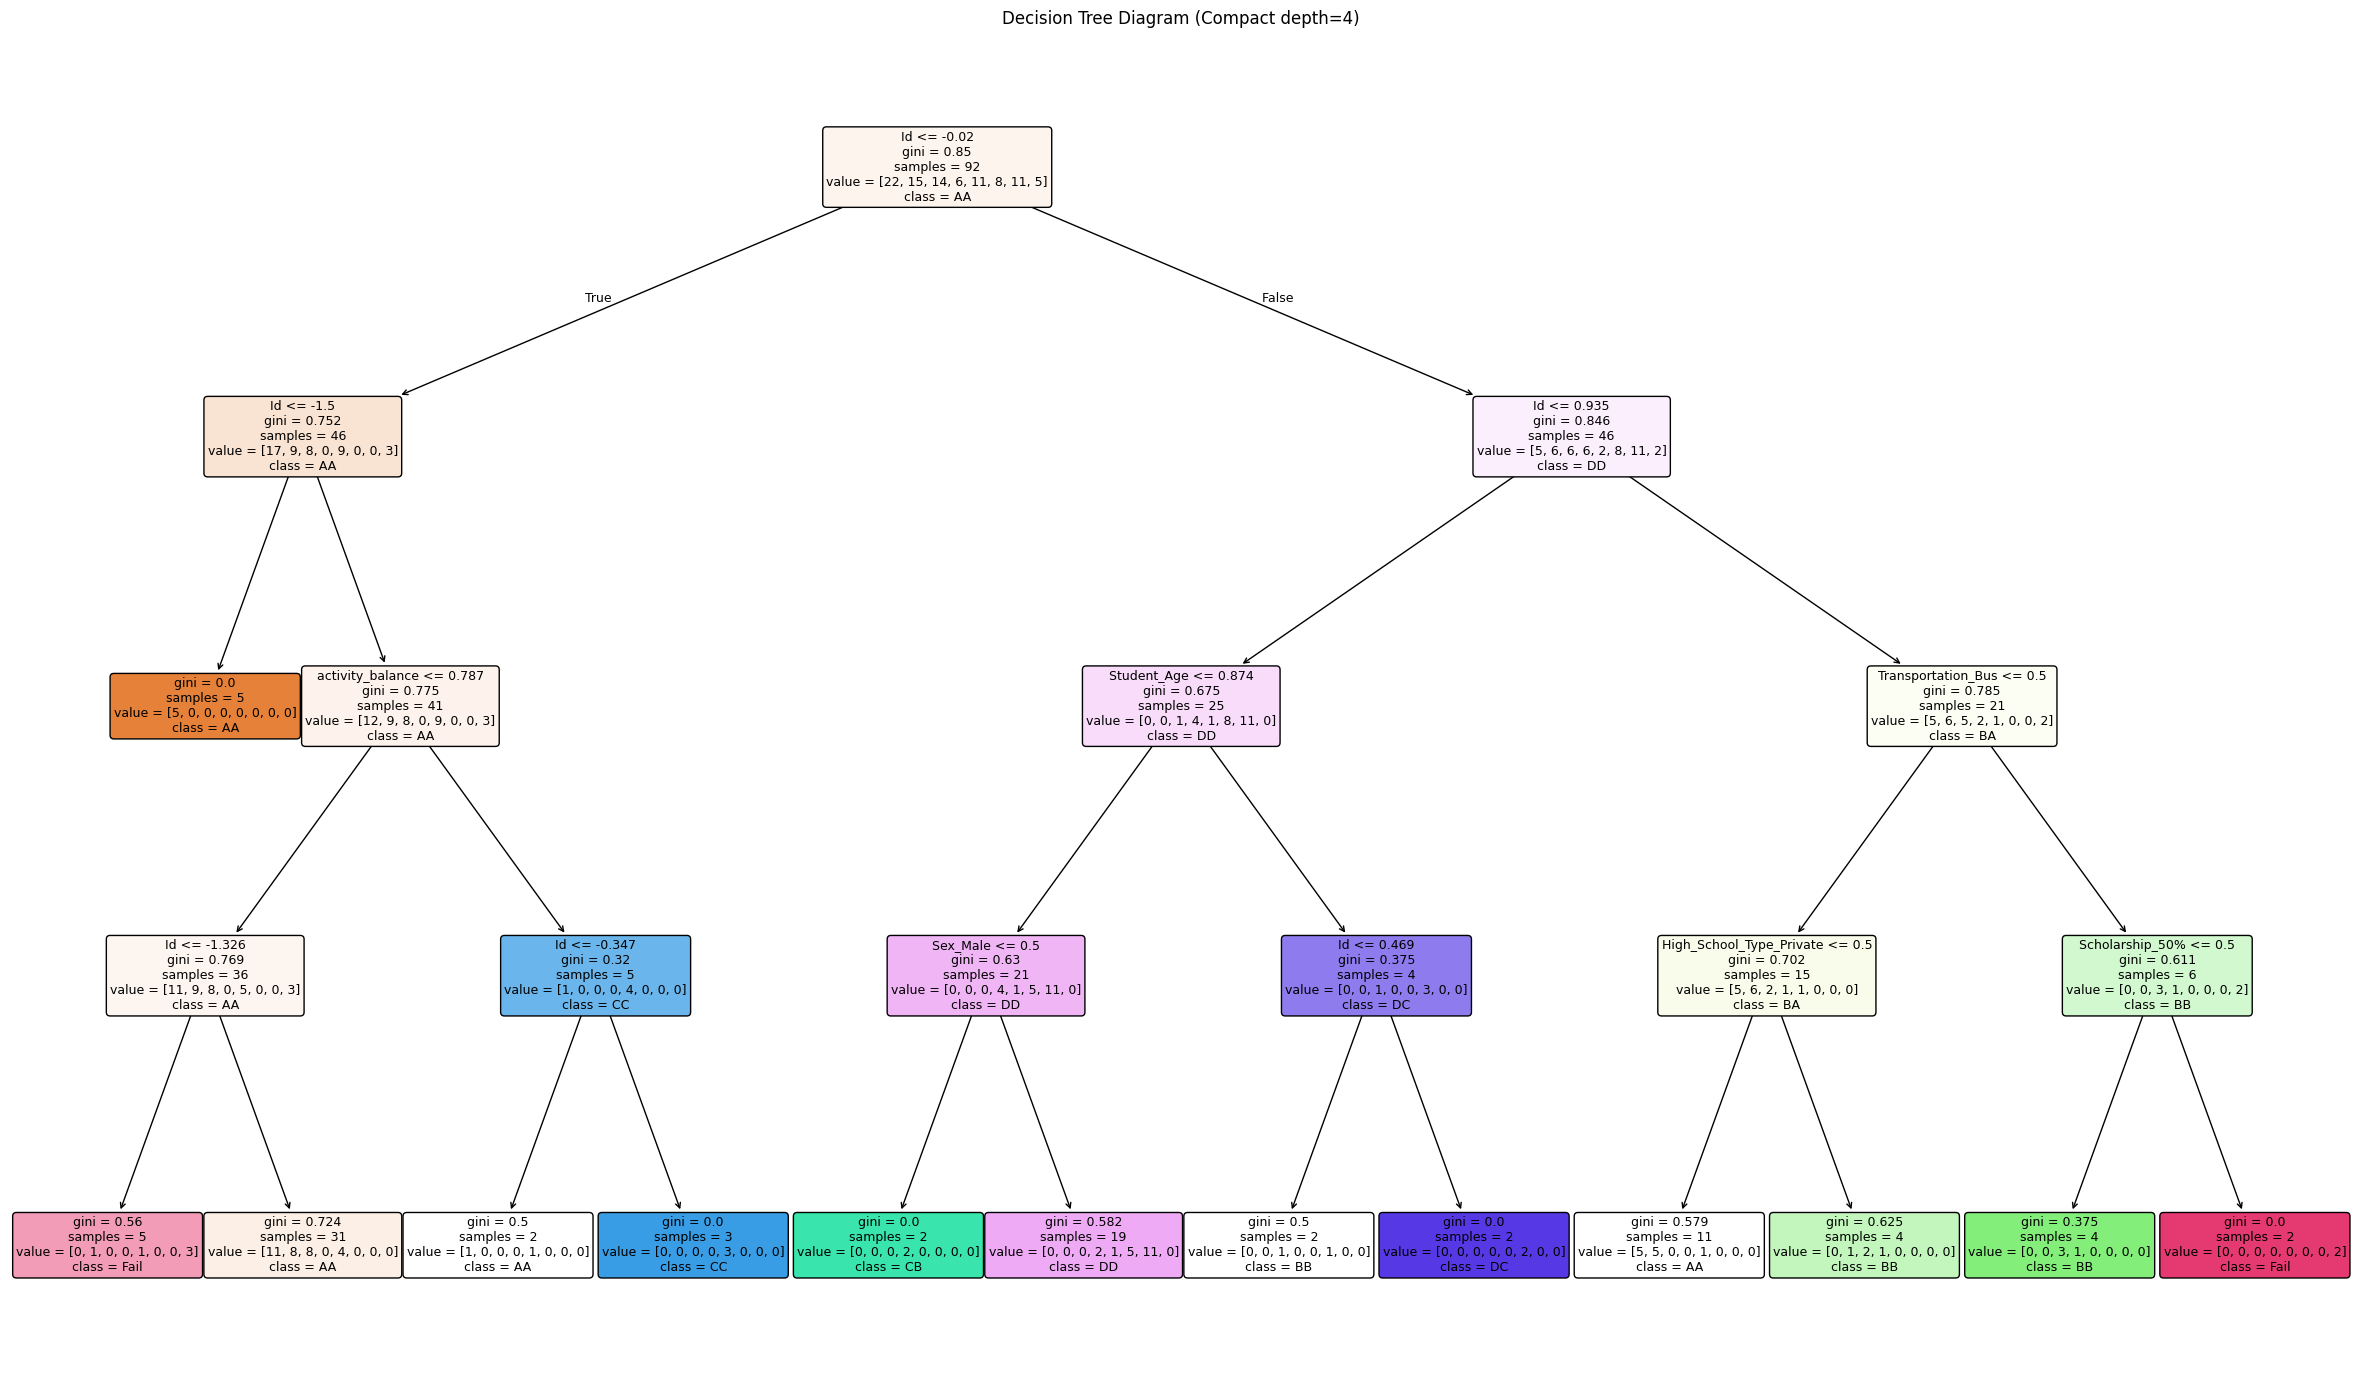

Best DT params: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5} | CV macro-F1: 0.2826

Decision Tree — Test
Accuracy: 0.2069
              precision    recall  f1-score   support

          AA     0.5000    0.1429    0.2222         7
          BA     0.6667    0.4000    0.5000         5
          BB     0.0000    0.0000    0.0000         4
          CB     0.0000    0.0000    0.0000         2
          CC     0.1111    0.3333    0.1667         3
          DC     0.0000    0.0000    0.0000         3
          DD     0.2857    0.6667    0.4000         3
        Fail     0.0000    0.0000    0.0000         2

    accuracy                         0.2069        29
   macro avg     0.1954    0.1929    0.1611        29
weighted avg     0.2767    0.2069    0.1985        29



<Figure size 640x480 with 0 Axes>

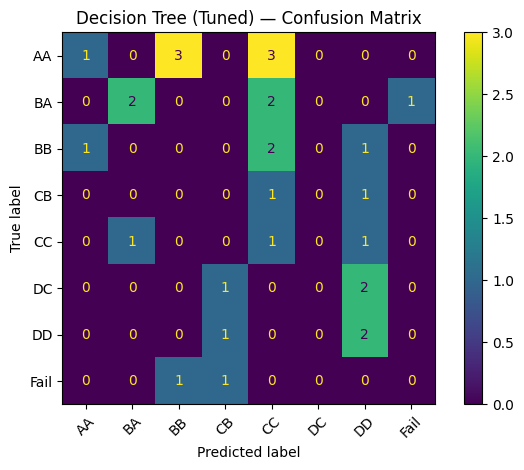

Best FNN config: {'width': 256, 'depth': 2, 'dropout': 0.3, 'lr': 0.0005} | Val macro-F1: 0.1958

FNN — Test
Accuracy: 0.1034
              precision    recall  f1-score   support

          AA     0.0000    0.0000    0.0000         7
          BA     0.2500    0.2000    0.2222         5
          BB     0.0000    0.0000    0.0000         4
          CB     0.0000    0.0000    0.0000         2
          CC     0.2500    0.3333    0.2857         3
          DC     0.0000    0.0000    0.0000         3
          DD     0.2500    0.3333    0.2857         3
        Fail     0.0000    0.0000    0.0000         2

    accuracy                         0.1034        29
   macro avg     0.0938    0.1083    0.0992        29
weighted avg     0.0948    0.1034    0.0974        29



<Figure size 640x480 with 0 Axes>

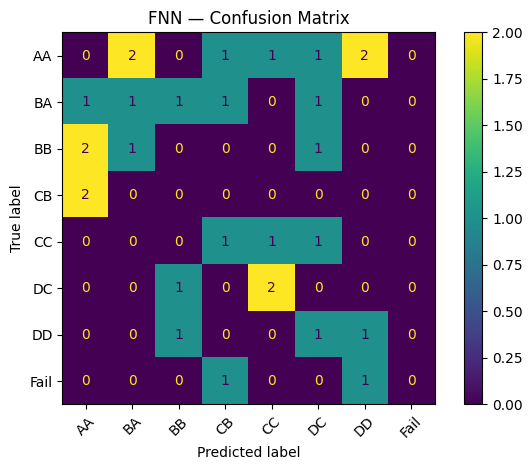

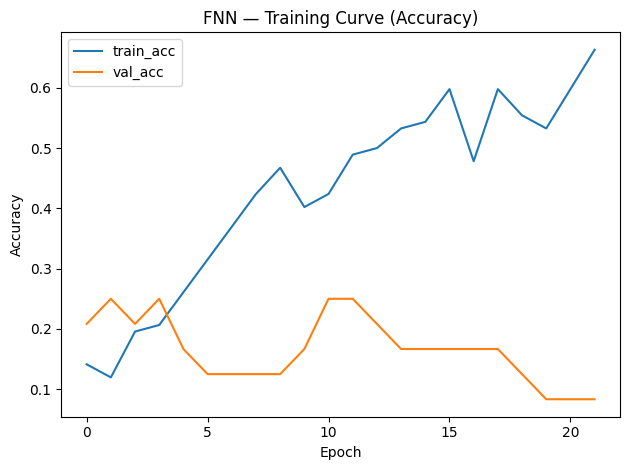

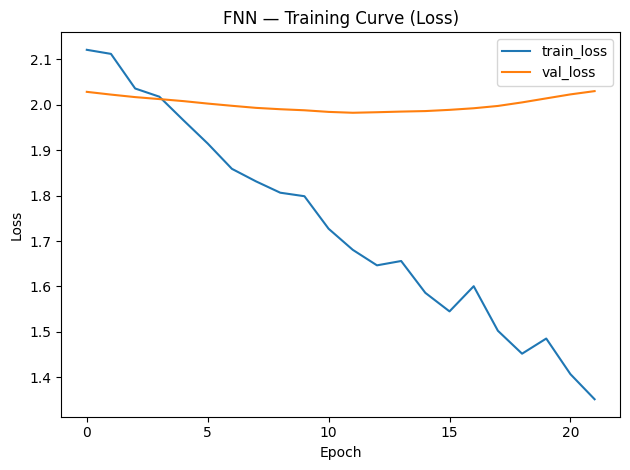


Hybrid — best alpha (val) = 0.00 | Val macro-F1 = 0.2330

Hybrid (Blending) — Test
Accuracy: 0.2069
              precision    recall  f1-score   support

          AA     0.5000    0.1429    0.2222         7
          BA     0.6667    0.4000    0.5000         5
          BB     0.0000    0.0000    0.0000         4
          CB     0.0000    0.0000    0.0000         2
          CC     0.1111    0.3333    0.1667         3
          DC     0.0000    0.0000    0.0000         3
          DD     0.2857    0.6667    0.4000         3
        Fail     0.0000    0.0000    0.0000         2

    accuracy                         0.2069        29
   macro avg     0.1954    0.1929    0.1611        29
weighted avg     0.2767    0.2069    0.1985        29



<Figure size 640x480 with 0 Axes>

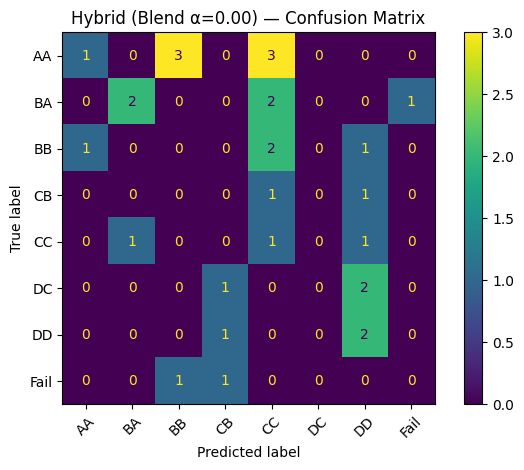


ROC-AUC — DT: 0.6047 | FNN: 0.5452 | Hybrid: 0.6047

Summary (sorted by Macro-F1 then Accuracy)
                Model  Accuracy  Macro-F1
Decision Tree (tuned)  0.206897  0.161111
      Hybrid (α=0.00)  0.206897  0.161111
          FNN (tuned)  0.103448  0.099206


In [4]:
# Modeling: Preprocessing + Decision Tree + FNN + Hybrid (Blending) with feature engineering
# Uses the SAME target detection and column typing as the EDA script.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Silence TF logging + typical retracing spam
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
tf.get_logger().setLevel("ERROR")   # reduce python-level TF warnings

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# 1) Load (same dataset)
CSV_PATH = r"C:\Data\student_classification_dataset.csv"
df = pd.read_csv(CSV_PATH).reset_index(drop=True)

# Feature Engineering for Student Classification Dataset
# Adds custom numeric features to enrich model input.

# 1. study_efficiency 
if "Attendance" in df.columns and "Weekly_Study_Hours" in df.columns:
    attendance_map = {"Always": 1.0, "Sometimes": 0.5, "Never": 0.0}
    df["attendance_score"] = df["Attendance"].map(attendance_map)
    df["study_efficiency"] = df["Weekly_Study_Hours"] * df["attendance_score"]

# 2. engagement_score 
engagement_cols = ["Reading", "Notes", "Listening_in_Class", "Project_work"]
for col in engagement_cols:
    if col in df.columns:
        df[col + "_bin"] = df[col].map({"Yes": 1, "No": 0})

available_bins = [c + "_bin" for c in engagement_cols if c + "_bin" in df.columns]
if available_bins:
    df["engagement_score"] = df[available_bins].sum(axis=1)

# 3. activity_balance 
if "Sports_activity" in df.columns and "Additional_Work" in df.columns:
    df["activity_balance"] = (
        df["Sports_activity"].map({"Yes": 1, "No": 0}) -
        df["Additional_Work"].map({"Yes": 1, "No": 0})
    )

# 4. travel_study_ratio
if "Transportation" in df.columns and "Weekly_Study_Hours" in df.columns:
    transport_map = {"Private": 1.0, "Public": 0.5, "Other": 0.8}
    df["travel_study_ratio"] = df["Weekly_Study_Hours"] * df["Transportation"].map(transport_map)

# Display confirmation
new_feats = [c for c in ["study_efficiency", "engagement_score", "activity_balance", "travel_study_ratio"] if c in df.columns]
print("\nNew engineered features added:", new_feats)
if new_feats:
    print(df[new_feats].head())

# Optional: drop obvious IDs
for col in ["id", "student_id", "index"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# 2) Target detection (identical to EDA)
possible_targets = ["performance_category", "class", "target", "label", "grade_category", "performance"]
target = next((c for c in possible_targets if c in df.columns), None)
if target is None:
    nonnum = [c for c in df.columns if df[c].dtype == "object"]
    target = nonnum[-1] if nonnum else df.columns[-1]
print("Target column:", target)

# 3) Types (EXACT match with EDA)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target]]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# 4) Split X/y
X = df.drop(columns=[target])
y_raw = df[target]
lbl = LabelEncoder()
y = lbl.fit_transform(y_raw)
class_names = [str(c) for c in lbl.classes_]
n_classes = len(class_names)

# Train/Val/Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# 5) Preprocessing — SAME rules as EDA
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  #OneHotEncoder turns categorical values into numeric columns of 0s and 1s.
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # handle unknown -if a new category appears in the test set
                                                                       # that wasn’t seen during training, it ignores it instead of crashing.
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),             # Fills missing numeric values with the median of that column
    ("scaler", StandardScaler())                               # Normalizes numeric values so each has mean = 0 and standard deviation = 1.
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),      # replaces missing categorical values with the most common value
    ("onehot", ohe)
])

preproc = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
], remainder="drop")

# Fit on training; transform sets
X_train_t = preproc.fit_transform(X_train)
X_val_t   = preproc.transform(X_val)
X_test_t  = preproc.transform(X_test)

# Helper: feature names for diagrams/importance
def get_feature_names(ct: ColumnTransformer) -> list:   #Takes your trained ColumnTransformer (preproc) as input.
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":   #If there are leftover columns not processed, skip them.
            continue
        if hasattr(trans, "named_steps"):   #hasattr mean has attribute, returns True if obj has a property or method named "attr"
            oh = trans.named_steps.get("onehot", None)
            if oh is not None and hasattr(oh, "get_feature_names_out"):   #uses the built-in get_feature_names_out() method to get new column names
                names.extend(list(oh.get_feature_names_out(cols))) 
            else:
                names.extend(list(cols))   #if not just keeps the original column names.
        else:
            names.extend(list(cols))     #This handles simple transformers
    return names

try:
    feature_names = np.array(get_feature_names(preproc))
except Exception:
    feature_names = np.array([f"f_{i}" for i in range(X_train_t.shape[1])])

# 6) Decision Tree — (A) compact diagram, (B) tuned model
dt_compact = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=2) 
dt_compact.fit(X_train_t, y_train)                            # rs = ensures results are reproducible every time you run the code.
#fit means “learn from data.”                                 # md = limits how deep the tree can grow. Prevents overfitting
plt.figure(figsize=(24, 14))
plot_tree(
    dt_compact,                                             # the trained Decision Tree model.
    feature_names=feature_names,                            # shows the actual names of your input features
    class_names=class_names,                                # shows the student performance categories
    filled=True, rounded=True, fontsize=9, impurity=True    # design of the box
)
plt.title("Decision Tree Diagram (Compact depth=4)")
plt.tight_layout()
plt.savefig("decision_tree_diagram.png", dpi=220)
plt.show()

# (B) Tuned DT for performance
dt_pipe = Pipeline([
    ("pre", preproc),
    ("dt", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "dt__max_depth": [None, 3, 5, 8, 12, 16],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 4, 8],
    "dt__class_weight": [None, "balanced"]
}

counts = np.bincount(y_train)
safe_splits = int(max(2, min(5, counts.min())))  # avoid tiny-class CV errors
cv = StratifiedKFold(n_splits=safe_splits, shuffle=True, random_state=42)

gs_dt = GridSearchCV(dt_pipe, param_grid_dt, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_
print("Best DT params:", gs_dt.best_params_, "| CV macro-F1:", round(gs_dt.best_score_, 4))

# DT predictions & probs
dt_val_proba  = best_dt.predict_proba(X_val)
dt_test_proba = best_dt.predict_proba(X_test)
y_test_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree — Test")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_dt), 4))
print(classification_report(y_test, y_test_pred_dt, target_names=class_names, digits=4, zero_division=0))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_dt, display_labels=class_names, xticks_rotation=45)
plt.title("Decision Tree (Tuned) — Confusion Matrix")
plt.tight_layout(); plt.show()

# 7) FNN — tuned light search, minimized retracing, with training curves
tf.random.set_seed(42)    #Ensures reproducibility of results
np.random.seed(42)       
#calculates a weight for each class to counter class imbalance.
class_weights = {i: (len(y_train)/(n_classes * max(np.sum(y_train==i),1))) for i in range(n_classes)}  #
                  #total samples                   # number of samples for class i         
def build_fnn(input_dim, n_classes, width=128, depth=2, dropout=0.2, lr=1e-3):   # number of features in your dataset,total number of target classes.
    m = Sequential([Input(shape=(input_dim,))])                           
    for _ in range(depth):                                      # d= how many hidden layers ,w= number of neurons per hidden layer                        
        m.add(Dense(width, activation="relu"))                  # relu = Rectified Linear Unit, helps the model learn complex pattern
        if dropout > 0: m.add(Dropout(dropout))                 #randomly "drops" some neurons to prevent overfitting 
    m.add(Dense(n_classes, activation="softmax"))               #softmax → gives probability distribution across classes
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),      # opt imizer: Adam with custom learning rate.
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])   #used for multi-class classification when labels are integers
    return m

search = [       #Hyperparameter Tuning
    {"width": 64,  "depth": 1, "dropout": 0.1, "lr": 1e-3},  #The code will try all three and pick the one that performs best
    {"width": 128, "depth": 2, "dropout": 0.2, "lr": 1e-3},
    {"width": 256, "depth": 2, "dropout": 0.3, "lr": 5e-4},
]

best_model, best_cfg, best_f1 = None, None, -np.inf
best_history = None               #Stops training early if the validation loss doesn’t improve for 10 epochs.
early = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
                                                                   #ensures the model goes back to the best epoch weights, not the last one.
for cfg in search:
    K.clear_session()    #resets the TensorFlow session to free memory before training the next model.
    m = build_fnn(X_train_t.shape[1], n_classes, **cfg)    #cfg= build model using current hyperparameters
    h = m.fit(
        X_train_t, y_train,
        validation_data=(X_val_t, y_val),    #Validation set for monitoring overfitting
        epochs=200, batch_size=32,
        callbacks=[early], verbose=0,       #verbosity control parameter decides how much output (text logs) you see during training or prediction.
        class_weight=class_weights
    )                                              
    y_val_pred = np.argmax(m.predict(X_val_t, verbose=0), axis=1)    #converts probabilities to class labels.
    f1 = f1_score(y_val, y_val_pred, average="macro")     #Compute the F1-score for each class individually
    if f1 > best_f1:
        best_f1, best_cfg, best_model, best_history = f1, cfg, m, h

print("Best FNN config:", best_cfg, "| Val macro-F1:", round(best_f1, 4))

ann_val_proba  = best_model.predict(X_val_t, verbose=0)
ann_test_proba = best_model.predict(X_test_t, verbose=0)
y_test_pred_fnn = np.argmax(ann_test_proba, axis=1)

print("\nFNN — Test")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_fnn), 4))
print(classification_report(y_test, y_test_pred_fnn, target_names=class_names, digits=4, zero_division=0))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_fnn, display_labels=class_names, xticks_rotation=45)
plt.title("FNN — Confusion Matrix")
plt.tight_layout(); plt.show()

# FNN training curves (best run)
if best_history is not None:
    hist = best_history.history
    plt.figure()
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FNN — Training Curve (Accuracy)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FNN — Training Curve (Loss)")
    plt.legend(); plt.tight_layout(); plt.show()

# 8) Hybrid — probability blending (alpha tuned on validation)
alphas = np.linspace(0, 1, 101)    #Create 101 evenly spaced α values from 0.00 to 1.00.
best_alpha, best_f1_h = None, -np.inf

for a in alphas:   #is the blending weight between the two models (0 = only DT, 1 =only FNN , 0.5 = both) , Loop through all 101 α values.
    blend_val = (1 - a) * dt_val_proba + a * ann_val_proba #matrices of validation probabilities from the tuned Decision Tree and FNN. Shape
    y_val_hat = blend_val.argmax(axis=1)  #chooses the class with the highest probability for each sample.
    f1 = f1_score(y_val, y_val_hat, average="macro")   #Computes macro F1-score on the validation set,checks how the blended model performs for this α.
    if f1 > best_f1_h:                   # If this α gives a better F1-score than previous ones, update best values.
        best_f1_h, best_alpha = f1, a    #store the alpha that gives the highest validation macro-F1.

print(f"\nHybrid — best alpha (val) = {best_alpha:.2f} | Val macro-F1 = {best_f1_h:.4f}")

blend_test = (1 - best_alpha) * dt_test_proba + best_alpha * ann_test_proba   #Uses the best alpha found from validation tuning
y_test_pred_h = blend_test.argmax(axis=1)

print("\nHybrid (Blending) — Test")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_h), 4))
print(classification_report(y_test, y_test_pred_h, target_names=class_names, digits=4, zero_division=0))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_h, display_labels=class_names, xticks_rotation=45)
plt.title(f"Hybrid (Blend α={best_alpha:.2f}) — Confusion Matrix")
plt.tight_layout(); plt.show()

# Optional: ROC-AUC
try:   #used for error handling, If something goes wrong, the code won’t crash; instead, it prints an error message
    if n_classes == 2:   #This checks whether your classification problem has 2 classes (binary) or more than 2 (multi-class).
        auc_dt  = roc_auc_score(y_test, dt_test_proba[:,1])   #computes the AUC (Area Under the ROC Curve).
        auc_ann = roc_auc_score(y_test, ann_test_proba[:,1])  #selects the predicted probability for the positive class (class 1).
        auc_h   = roc_auc_score(y_test, blend_test[:,1])      #means the model is better at distinguishing between the two classes.
    else:
        auc_dt  = roc_auc_score(y_test, dt_test_proba,  multi_class="ovr")  #"ovo" (One-vs-One), but "ovr" is more common for multi-class problems
        auc_ann = roc_auc_score(y_test, ann_test_proba, multi_class="ovr")  # "ovr"compute AUC for each class treated as positive vs
        auc_h   = roc_auc_score(y_test, blend_test,     multi_class="ovr")  # all others negative,then average the results.
    print(f"\nROC-AUC — DT: {auc_dt:.4f} | FNN: {auc_ann:.4f} | Hybrid: {auc_h:.4f}")
except Exception as e:
    print("ROC-AUC skipped:", e)

# 9) Summary
acc_dt  = accuracy_score(y_test, y_test_pred_dt)
acc_ann = accuracy_score(y_test, y_test_pred_fnn)
acc_h   = accuracy_score(y_test, y_test_pred_h)

f1_dt   = f1_score(y_test, y_test_pred_dt,  average="macro")
f1_ann  = f1_score(y_test, y_test_pred_fnn, average="macro")
f1_h    = f1_score(y_test, y_test_pred_h,   average="macro")

summary = pd.DataFrame({
    "Model": ["Decision Tree (tuned)", "FNN (tuned)", f"Hybrid (α={best_alpha:.2f})"],
    "Accuracy": [acc_dt, acc_ann, acc_h],
    "Macro-F1": [f1_dt, f1_ann, f1_h]
}).sort_values(["Macro-F1", "Accuracy"], ascending=False)

print("\nSummary (sorted by Macro-F1 then Accuracy)")
print(summary.to_string(index=False))
